In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit

On considère dans ce cas l'équation de Burgers suivante:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0 \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [155]:


#La Solution Iniciale:
@njit
def u0(x):
    if  x <=1/4:
        return ul
    if  x >1/4 and x <3/4:
        return um
    else:
        return ur
    
def u0_sin(x):
    return np.cos(2*np.pi*x)


# La Solution Exacte:
@njit
def Uex(t,x):
    if x>=0 and x<=0.5:
        if x-(1/4)<= ul*t:
            return ul

        elif x-(1/4)>ul*t and x-(1/4)< um*t:
            return (x-(1/4))/t

        elif x-(1/4)>=um*t:
            return um
    else:
        if x-(3/4)<0.5*(um+ur)*t:
            return um
        else:
            return ur
        
@njit
def Uex(t,x):
    if T<=1/2:
        if x>=0.75 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    elif T>0.5 and T<=1:
        if x>=1.2 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    elif T>1 and T<=1.8:
        if x>=1.5 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    elif T>1.8 and T<=2:
        if x>=1.87 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    elif T>2:
        if x-(1/4)<= ul*t:
                return ul

        elif x-(1/4)>ul*t and x-(1/4)< um*t:
            return (x-(1/4))/t
        elif x-(1/4)>=um*t:
            return um
    
    

# Le flux Exacte:
@njit
def F(u):
    return (u**2)/2

# Les Flux des schemas:
@njit
def Rusanov(ug,ud,dx,dt):
    lamda= max(abs(ug),abs(ud))
    return 0.5*(F(ug)+F(ud))-lamda*(ud-ug)

@njit
def Rusanov2(ug,ud,dx,dt):
    lamda= max(abs(ug),abs(ud))
    return 0.5*(F(ug)+F(ud)-lamda*(ud-ug))

@njit
def Roe(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - (ug+ud)/2 *(ud-ug) )
  
@njit
def LF(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - (dx/dt) *(ud-ug) )

@njit
def LFM(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - 0.5*(dx/dt) *(ud-ug) )

@njit
def LW(ug, ud, dx, dt):
    A = 0.5 * (ud + ug)
    return 0.5 * (F(ug) + F(ud) - (dt / dx) * A * (F(ud) - F(ug)))

@njit
def departure(dt, alpha, X, u):
    aux = 1.0
    eps = 1e-9

    x0 = 0.5 * (X[:-1] + X[1:])
    xmp = x0

    while aux > eps:
        x1 = xmp - dt * alpha * np.mean(u)
        aux = np.max(np.abs(x1 - x0))

        x0 = x1

    return x0

@njit(cache=True)
def depature_fvc_flux(dt,alpha,x,u):
    aux=1
    eps=1e-9
    x0=0.5*(x[0]+x[1])   
    x1=x0
    xmp=x0
    while(aux>eps):
        deriv=np.interp(x0, x, u)
        x1=xmp-dt*alpha*deriv
        aux=np.abs(x0-x1)
        x0=x1
    if x0>x[1]:
        x0=x[1]
    if x0<x[0]:
        x0=x[0]    
    return x0 

 
@njit(cache=True)
def fvc_flux(u,x,dt,alpha):
    
    Alpha = alpha
    x_car = depature_fvc_flux(dt, Alpha,x,  u)

    up   = np.interp(x_car, x, u)
    

    return 0.5 * up**2

@njit
def VFC(U0, T, a, N,  alpha, dx, CFL):
    Un    = U0.copy()
    Unp1  = np.zeros(N)
    
    temps = 0
    
    
    while temps < T:
        dt  = CFL*(dx/(np.max(np.abs(Un))*np.sqrt(2*alpha)))

                
        temps += min(dt,T-dt)
        
        for i in range(1,N-1):
            X1   = [X[i-1],X[i]]
            u1   = [Un[i-1],Un[i]]
            
            X2   = [X[i],X[i+1]]
            u2   = [Un[i],Un[i+1]]
            
            Fg  = fvc_flux(u1,X1,dt,alpha)
            Fd  = fvc_flux(u2,X2,dt,alpha)
            
            Unp1[i]=Un[i]-dt/dx*(Fd-Fg) 
            
        Unp1[0]   = Unp1[1]
        Unp1[N-1] = Unp1[N-2]
        Un = Unp1.copy()
    return Un




@njit
def NonLinearBurgerSolver(U0, T, l, L, N, dx, CFL, scheme):
    if scheme == 0:
        flux = Roe 
    elif scheme == 1:
        flux = Rusanov
    elif scheme == 2:
        flux = Rusanov2
    elif scheme == 3:
        flux = LF
    elif scheme == 4:
        flux = LFM
    elif scheme == 5:
        flux = LW
    

    Un = U0.copy()
    Unp1 = np.zeros(N)
    temps = 0
    while temps < T:
        dt = CFL*dx/np.max(np.abs(Un))
        temps += min(dt,T-dt)
        for i in range(1,N-1):
            Fd = flux(Un[i],Un[i+1],dx,dt)
            Fg = flux(Un[i-1],Un[i],dx,dt)
            Unp1[i] = Un[i]-dt/dx*(Fd-Fg)

        Unp1[0] = Unp1[1]
        Unp1[N-1] = Unp1[N-2]


        Un = Unp1.copy()
        

    return Un

###################################################################################
ul    = 0.2
um    = 0.8
ur    = 0.4
T     = 1
l     = 0
L     = 2
a     = 2
N     = 101
CFL   = 1/2
alpha = 1
X     = np.linspace(l,L,N)
dx    = (L-l)/(N-1)
U0    = np.array([u0(x) for x in X])

f = {}

fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):1, ("LF",3):1, ("LFM",4):1, ("LW",5):1}

for i,j in fluxes.items():  
    if j:
        f[i[0]]  =  NonLinearBurgerSolver  (U0, T, l, L, N, dx, CFL, i[1])  
    
f["VFC"] = VFC(U0, T, a, N,  alpha, dx, CFL)
    

UExact = np.array([Uex(T,x) for x in X])

/tmp/ipykernel_11983/2334889969.py:237: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i in range(1,N-1):


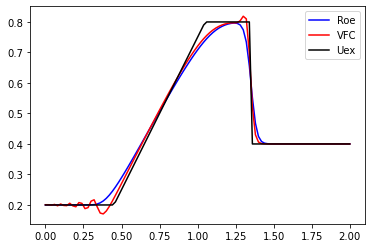

In [156]:
PLOT = {"Roe":1, "Rusanov":0, "Rusanov2":0, "LF":0, "LFM":0, "LW":0, "VFC":1 }

colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'red']


for i, (flux, Un) in enumerate(f.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, '-', label=flux, color=colors[i])
    
plt.plot(X, UExact, '-k',  label='Uex')

#plt.xlim([-0.05, 0.05])  
#plt.ylim([0.6, 0.9])  

plt.legend()
plt.pause(0.1)


In [14]:
Norm = {}
for i, (flux, Un) in enumerate(f.items()):
    Norm[flux]    =  np.linalg.norm(Un,ord = 2) 
Norm

{'Roe': 6.859184750405006,
 'Rusanov': 6.797433759562545,
 'Rusanov2': 6.854682412681114,
 'LF': 6.755618168522382,
 'LFM': 6.828303270077594,
 'LW': 6.910317992830085,
 'VFC': 6.906709868736888}